# CIFAR10 with fastai
A few years ago I spent some time playing around with [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). This is a dataset consisting of 10 classes, 50,000 for training and 10,000 for testing. Each image is 32x32 RGB. Back then I had an old CUDA card that didn't support any of the popular frameworks for machine learning. So I ended up writing my own CNN code using CUDA from scratch. This took a bit of time but it was fun. My results were okay back then, a bit over 80% accuracy for validationa and testing. In this post I'm revisting CIFAR10 but this time I'm going to use fastai. I'm expecting to get much better results with less effort this time!

My initial attempts to train on my laptop's GeForce MX250 kept freezing the laptop so I ended paying for some time on [Paperspace](https://www.paperspace.com/), which is one of the cloud service recommended on fastai's website.

1. [Load the CIFAR10 dataset](#load)
2. [Training](#train)
3. [Evaluate on test set](#test)
4. [Some thoughts](#thoughts)

# 1. Load the CIFAR10 dataset<a name="load"></a>
We can use fastai's builtin function to load CIFAR10. This is a convenient one liner.

In [27]:
from fastai.vision.all import *
from fastai.callback.fp16 import *

path = untar_data(URLs.CIFAR)

# 2. Training<a name="train"></a>
I'm going to use a pre-trained resnet18 and do transfer learning. In an attempt to speed things up (since I'm paying by the second on Paperspace!) I'll use float16 for training. This is done by calling .to_fp16() on the cnn_learner. Resnet was originally trained on images with size 224x224, but CIFAR10 images are smaller 32x32. This isn't a blocker, as we can train on any image size but it may not give good results. As an experiment I'll train on images of size 32x32, 64x64, 128x128 and 224x224. 

The training parameters are pretty simple. There's no data augmentation or any other tricks. The head is trained for 3 epochs and the rest for 10 epochs.

In [3]:
for s in [32, 64, 128, 224]:
    dblock = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
                       get_items=get_image_files,
                       get_y=parent_label,
                       item_tfms=Resize(s))

    dls = dblock.dataloaders(path, bs=64)

    learn = cnn_learner(dls, models.resnet18, metrics=accuracy).to_fp16()
    learn.fine_tune(10, freeze_epochs=3)
    learn.save(f"cifar10_{s}")
    
    # run on test set
    test_files = get_image_files(path / "test")
    label = TensorCategory([dls.vocab.o2i[parent_label(f)] for f in test_files])

    pred = learn.get_preds(dl=dls.test_dl(test_files))
    acc = accuracy(pred[0], label).item()
    print(f"{s}x{s}, test accuracy={acc}")

epoch,train_loss,valid_loss,accuracy,time
0,2.100647,1.665308,0.439083,00:52
1,1.594981,1.434067,0.498833,00:48
2,1.356714,1.262811,0.549917,00:46


epoch,train_loss,valid_loss,accuracy,time
0,1.019352,0.934307,0.673667,00:59
1,0.796791,0.765745,0.733250,01:00
2,0.679803,0.691959,0.759583,01:00
3,0.529216,0.671557,0.774333,01:00
4,0.384610,0.685909,0.784083,01:00
5,0.250764,0.778496,0.778833,01:00
6,0.183144,0.842402,0.781333,01:01
7,0.100487,0.916304,0.784333,00:59
8,0.069740,0.957944,0.786583,00:59
9,0.056327,0.979944,0.785667,00:59


32x32, test accuracy=0.9575999975204468


epoch,train_loss,valid_loss,accuracy,time
0,1.420881,1.049973,0.647333,00:54
1,0.991421,0.811920,0.714667,00:53
2,0.779609,0.643858,0.777083,00:52


epoch,train_loss,valid_loss,accuracy,time
0,0.484774,0.416703,0.853833,01:12
1,0.339335,0.371605,0.872917,01:12
2,0.273515,0.380237,0.877417,01:11
3,0.173647,0.372660,0.887500,01:11
4,0.094830,0.427521,0.888917,01:12
5,0.062262,0.442552,0.890417,01:12
6,0.027331,0.441486,0.899500,01:12
7,0.010195,0.472872,0.901083,01:11
8,0.006250,0.472683,0.904167,01:12
9,0.004829,0.471941,0.903333,01:12


64x64, test accuracy=0.9786999821662903


epoch,train_loss,valid_loss,accuracy,time
0,0.833816,0.576824,0.806750,01:37
1,0.513530,0.417383,0.855250,01:36
2,0.405045,0.331512,0.886667,01:36


epoch,train_loss,valid_loss,accuracy,time
0,0.253418,0.220973,0.926083,02:14
1,0.182245,0.234754,0.921750,02:14
2,0.132614,0.244895,0.927083,02:14
3,0.084338,0.247453,0.930750,02:14
4,0.056695,0.238229,0.938417,02:14
5,0.029391,0.251964,0.941667,02:14
6,0.017820,0.253129,0.944083,02:14
7,0.006714,0.249118,0.946250,02:14
8,0.001866,0.242552,0.949583,02:14
9,0.002502,0.240354,0.950083,02:14


128x128, test accuracy=0.9901999831199646


epoch,train_loss,valid_loss,accuracy,time
0,0.843357,0.569814,0.809250,03:43
1,0.515265,0.401480,0.863750,03:41
2,0.384910,0.296032,0.897750,03:41


epoch,train_loss,valid_loss,accuracy,time
0,0.245304,0.191707,0.933417,05:23
1,0.175666,0.195338,0.934417,05:23
2,0.134257,0.213976,0.933583,05:23
3,0.081742,0.234396,0.931417,05:23
4,0.048711,0.216106,0.943917,05:23
5,0.030225,0.209014,0.947250,05:23
6,0.014432,0.205015,0.950500,05:23
7,0.005968,0.204015,0.952083,05:23
8,0.004300,0.194105,0.955833,05:23
9,0.002422,0.195443,0.954250,05:24


224x224, test accuracy=0.9900000095367432


As the image size increases so does the validation accuracy. The accuray plateaus after 128x128. Interstingly, the test dataset has higher much accuracy (99%) than the validation (95%), don't see that everyday. Already this is much better result than I ever achieved with my custom code I wrote years ago. The best result is an accuracy of >99% according to [benchmarks.ai](https://benchmarks.ai/cifar-10), so we're not doing too bad for so little effort!

# 3. Evaluate on test set<a name="test"></a>
I'm going to re-run on the test set and collect some data to plot a graph. 

In [ ]:
xs = []
ys = []
best_s = []
best_acc = 0
best_learn = None

for s in [32, 64, 128, 224]:
    # TODO: find a better way to do this
    dblock = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
                       get_items=get_image_files,
                       get_y=parent_label,
                       item_tfms=Resize(s))

    dls = dblock.dataloaders(path, bs=64)
    
    learn = cnn_learner(dls, models.resnet18, metrics=accuracy).to_fp16()
    learn.load(f"cifar10_{s}")
    
    test_files = get_image_files(path / "test")
    label = TensorCategory([dls.vocab.o2i[parent_label(f)] for f in test_files])
    
    pred = learn.get_preds(dl=dls.test_dl(test_files))
    acc = accuracy(pred[0], label).item()
    
    if acc > best_acc:
        best_s = s
        best_acc = acc
        best_learn = learn
        
    xs.append(s)
    ys.append(acc)
    
print(f"best image size: {best_s}")

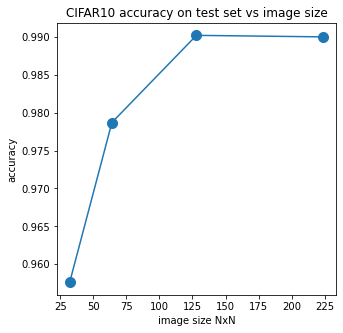

In [26]:
plt.figure(figsize=(5,5))
plt.plot(xs, ys, 'o-', markersize=10)
plt.xlabel("image size NxN")
plt.ylabel("accuracy")
plt.title("CIFAR10 accuracy on test set vs image size");

128x128 also performs the best on the test set. The accuracy is around 99%. Let's plot the confustion matrix and some of the top losses.

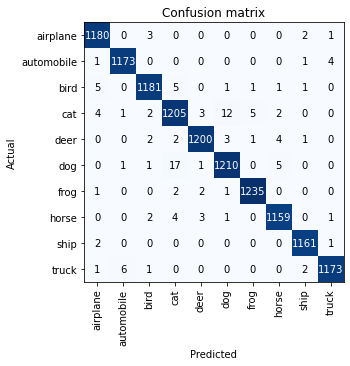

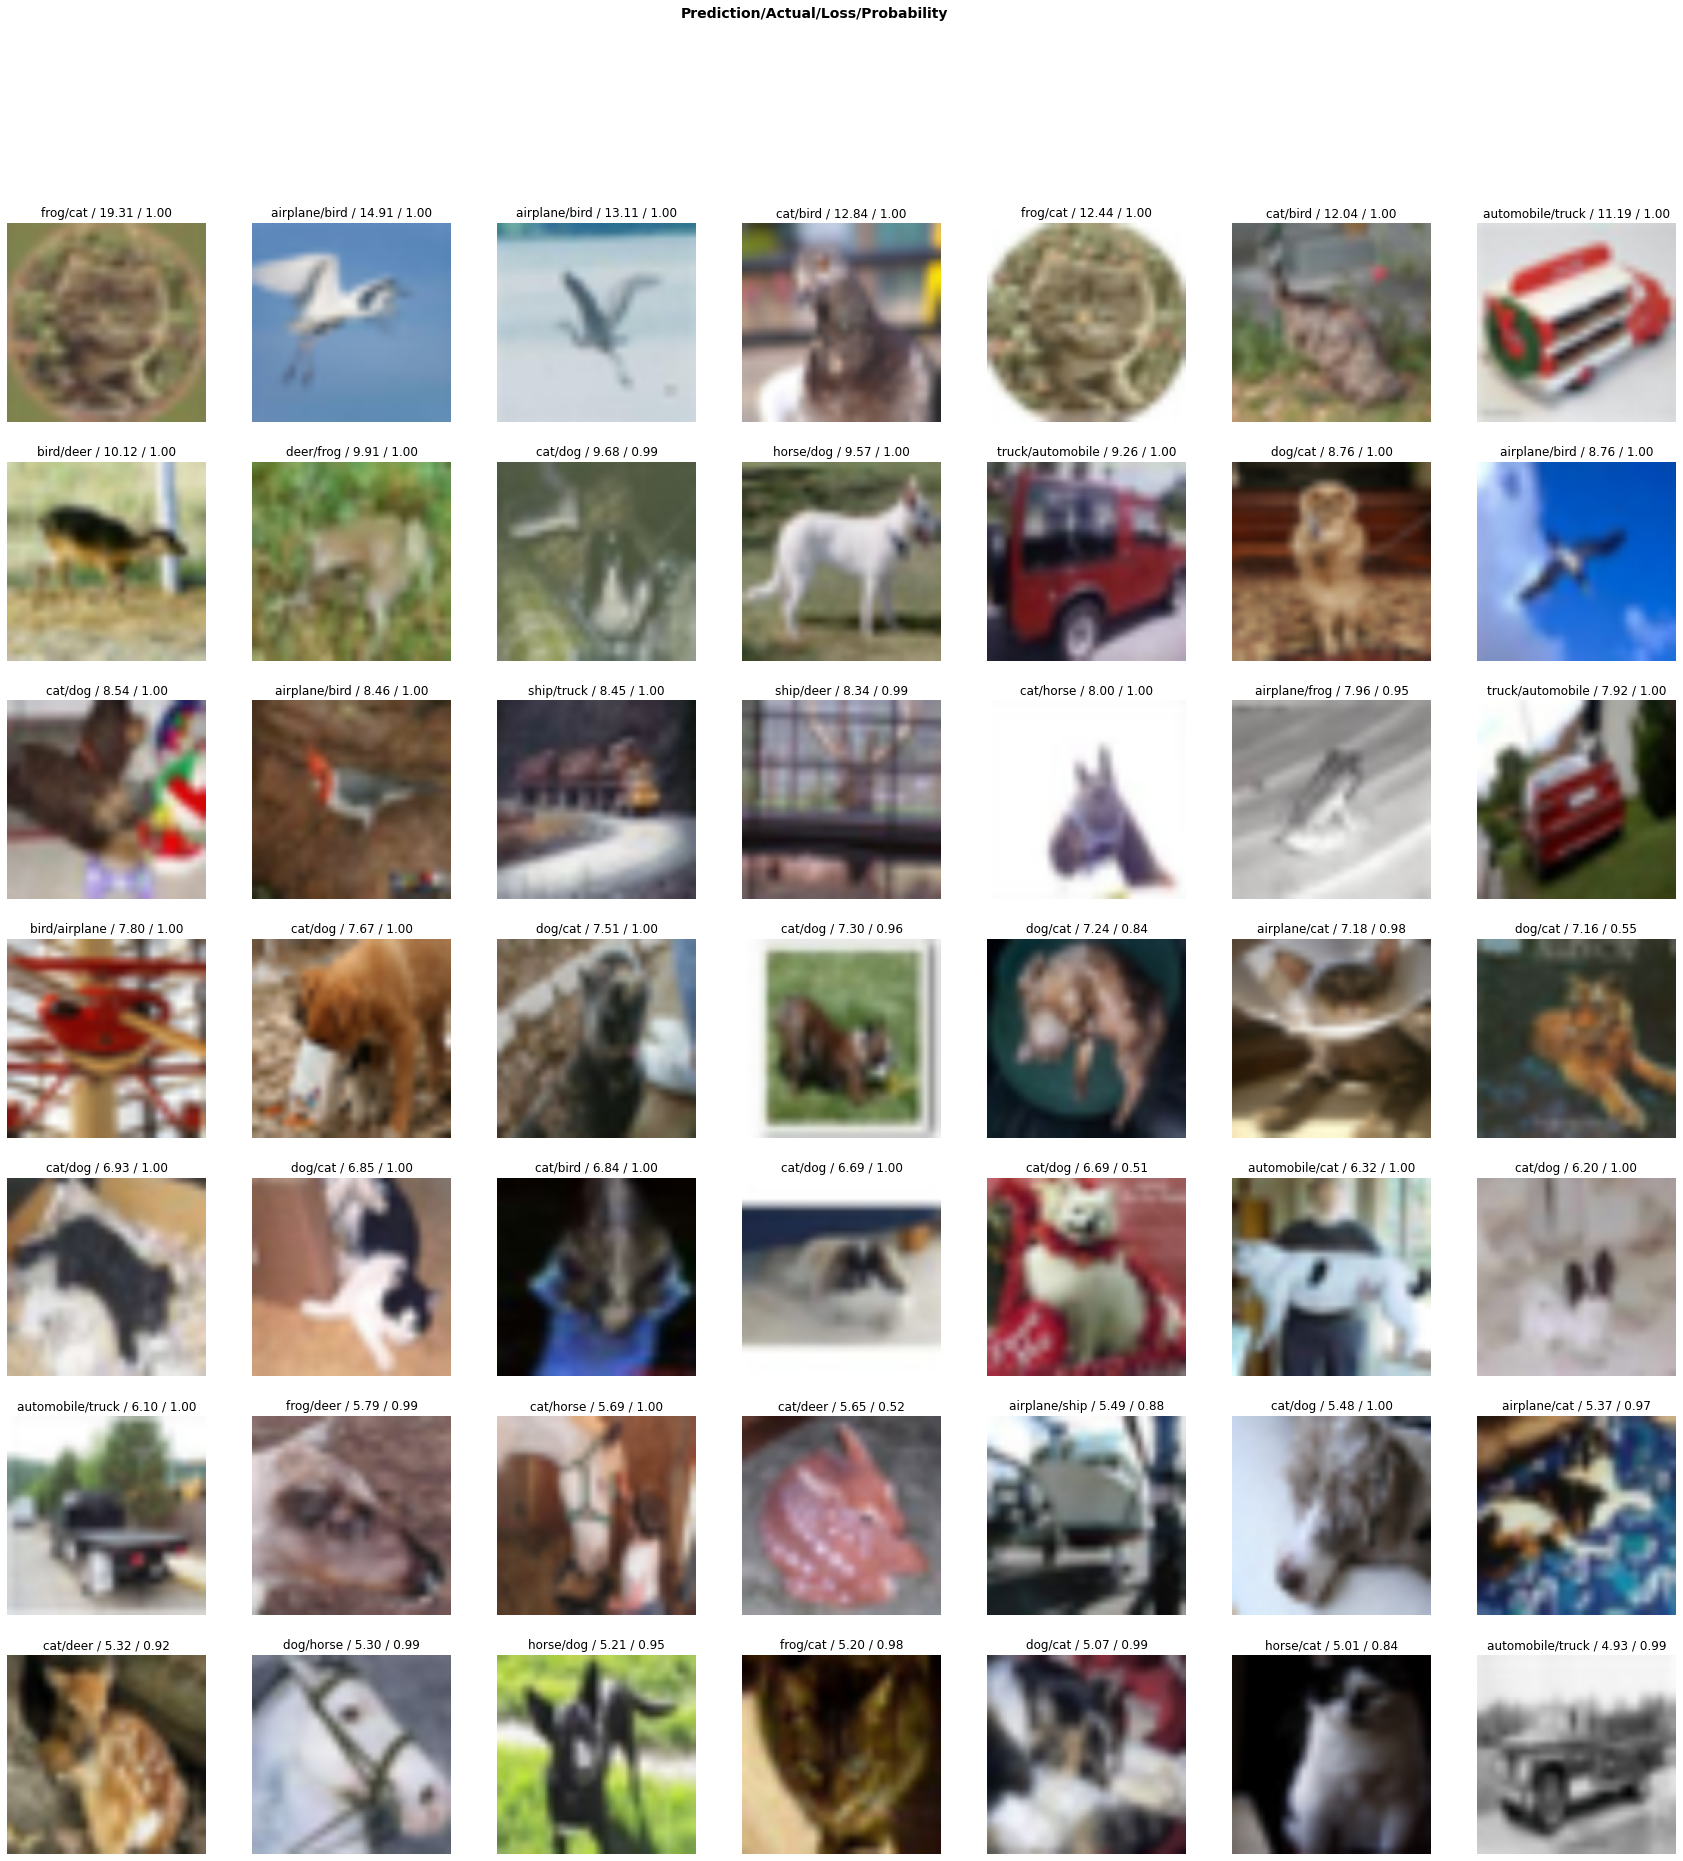

In [33]:
interp = ClassificationInterpretation.from_learner(best_learn)
interp.plot_confusion_matrix(figsize=(5,5))
interp.plot_top_losses(49, figsize=(30,30))

I noticed the 1st and 4th images are nearly identical, what's going on there? The highest confusion is between cats and dogs, followed by trucks and automobile.

# 4. Some thoughts<a name="thoughts">
We've seen how easy it is to get good accuracy on the CIFAR10 dataset. I got 95% accuracy for the validation and 99% accuracy for the test set with very little effort. I'm looking forward to using fastai on a real application.
    
I found using Paperspace a pretty smooth experience. The only annoying part is spinning up the virtual machine, it takes a while. 